<a href="https://colab.research.google.com/github/OmPanchal/lenet-using-tensorflow/blob/main/Lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import shutil
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Process
import time as time

## **Dataset**

In [ ]:
!unzip -o "/content/drive/MyDrive/Colab Notebooks/EnglishCharacters.zip" -d ""
!rm -r "train"

In [ ]:
english_csv = pd.read_csv("english.csv")
english_csv.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


In [ ]:
english_csv_np = english_csv.to_numpy()

In [ ]:
for filepath, label in english_csv_np[0: 10]:
    print(filepath, label)

Img/img001-001.png 0
Img/img001-002.png 0
Img/img001-003.png 0
Img/img001-004.png 0
Img/img001-005.png 0
Img/img001-006.png 0
Img/img001-007.png 0
Img/img001-008.png 0
Img/img001-009.png 0
Img/img001-010.png 0


In [ ]:
if not os.path.exists("train"): os.mkdir("train")

labels = np.unique(english_csv_np.T[1])
for label in labels:
    os.mkdir(os.path.join("train", label))

In [ ]:
len(labels)

62

In [ ]:
for f, l in english_csv_np:
    shutil.move(f, os.path.join("train", l))

os.rmdir("Img")

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory("train", shuffle=False).unbatch()
train_ds

Found 3410 files belonging to 62 classes.


<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

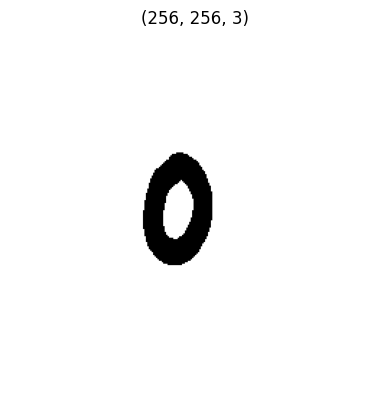

In [ ]:
for i, l in train_ds.shuffle(buffer_size=50).take(1):
    plt.title(str(i.shape))
    plt.axis("off")
    plt.imshow(i)

In [ ]:
train_ds = train_ds.map(lambda x, y: (x / 255, y))

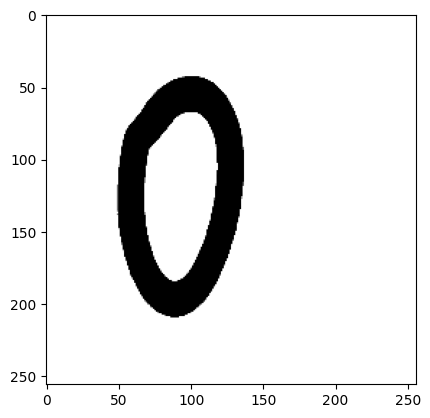

In [ ]:
plt.imshow(next(train_ds.as_numpy_iterator())[0])

## **Network**

### **Lenet**

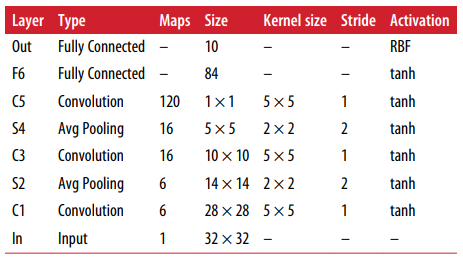

**Edits to the Architecture**
- Image size is 256 x 256 therefore larger feature maps while in the paper smaller sized images are used
- Since the output lenght of the network is 10 (for digits 0-9), as subset of the dataset will be used. The lowercase and uppercase characters will be ommited while the network will only be trained on the digits.
- Edits to a few layers might have to be made due to the larger size of the image such as additional fully connected layers or an increase in the number of kernels in the convolutional layers.
- Additional Layers will have to be added inbetween origional layers to downsample the feature maps back to the correct dimensions.

**Custom Architecture of LeNet**

- pooling layers have trainable scalar parameters (might implement by subclassing pooling layer).
>*Each unit computes the
average of its four inputs multiplies it by a trainable coeffcient adds a trainable bias and passes the result through a sigmoid function*
- Layer 3 connections of filters to subsets of images (might implement by editting the kernels). Portions of the kernels will be changed to 0 to connect the feature maps as specified in the paper.
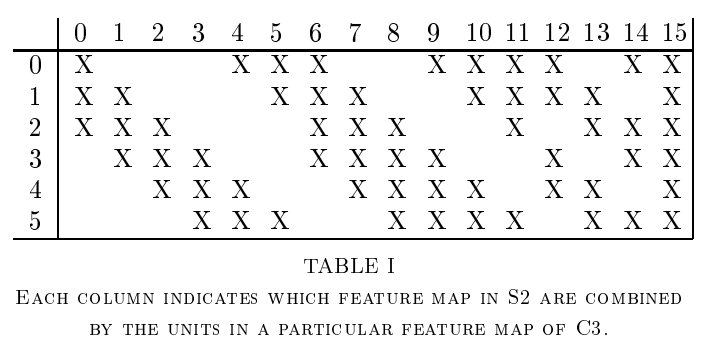
- Custom scaled tanh activation function
>*The function f is odd, with horizon
tal asymptotes at +A and -A The constant A is chosen
to be 1.7159*
- Final RBF layer (will implement using layer subclassing).

#### **Subclassed Dataset**

In [ ]:
subclassed_ds_dir = "subclassed_train"
if os.path.exists(subclassed_ds_dir):
    shutil.rmtree(subclassed_ds_dir)
os.mkdir(subclassed_ds_dir)

In [ ]:
dirs = os.listdir("train")
subclassed_dirs = []

if os.path.exists(subclassed_ds_dir):
    shutil.rmtree(subclassed_ds_dir)

for i in dirs:
    try:
        dir_path = os.path.join("train", str(int(i)))
        destination_path = os.path.join(subclassed_ds_dir, i)
        shutil.copytree(dir_path, destination_path)
    except Exception as e:
        print(f"{e}")

invalid literal for int() with base 10: 'J'
invalid literal for int() with base 10: 'H'
invalid literal for int() with base 10: 'v'
invalid literal for int() with base 10: 'V'
invalid literal for int() with base 10: 'n'
invalid literal for int() with base 10: 'O'
invalid literal for int() with base 10: 'C'
invalid literal for int() with base 10: 'Z'
invalid literal for int() with base 10: 'd'
invalid literal for int() with base 10: 'T'
invalid literal for int() with base 10: 'W'
invalid literal for int() with base 10: 'k'
invalid literal for int() with base 10: 's'
invalid literal for int() with base 10: 'E'
invalid literal for int() with base 10: 'P'
invalid literal for int() with base 10: 'B'
invalid literal for int() with base 10: 'l'
invalid literal for int() with base 10: 'X'
invalid literal for int() with base 10: 'y'
invalid literal for int() with base 10: 'j'
invalid literal for int() with base 10: 'w'
invalid literal for int() with base 10: 'o'
invalid literal for int() with b

In [ ]:
digit_ds = tf.keras.utils.image_dataset_from_directory(subclassed_ds_dir, label_mode="categorical").unbatch()
digit_ds = digit_ds.map(lambda x, y: (x / 255, y))

Found 550 files belonging to 10 classes.


(256, 256, 3)


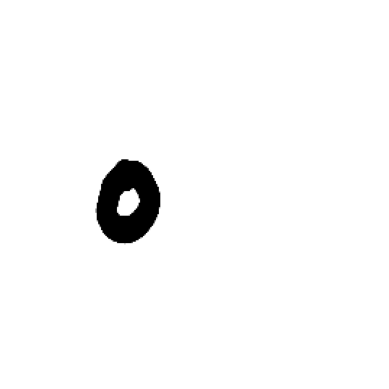

In [ ]:
random_digit = next(digit_ds.shuffle(buffer_size=50).as_numpy_iterator())

print(random_digit[0].shape)

plt.axis("off")
plt.imshow(random_digit[0])

#### **Padded mnist dataset**

In [ ]:
(mnist_train), (mnist_test) = tf.keras.datasets.mnist.load_data()
mnist_train, mnist_test

11490434/11490434 [==============================] - 0s 0us/step


((array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         ...,
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0

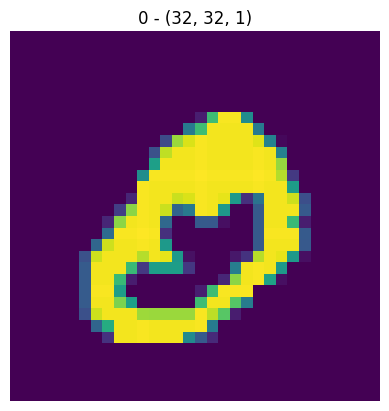

In [ ]:
def preprocess_image(x):
    x = tf.pad(x, paddings=tf.constant([[2, 2], [2, 2]]))
    return tf.cast(x / 255, dtype="float32")[..., tf.newaxis]

def preprocess_label(y):
    return tf.cast(tf.one_hot(indices=y, depth=10), dtype="float32")

mnist_ds = tf.data.Dataset.from_tensor_slices(mnist_train)
mnist_ds = mnist_ds.map(lambda x, y: (preprocess_image(x), preprocess_label(y)))
mnist_ds = mnist_ds.shuffle(buffer_size=128, reshuffle_each_iteration=True).prefetch(16)


val = next(mnist_ds.as_numpy_iterator())

plt.axis("off")
plt.title(f"{np.argmax(val[1])} - {val[0].shape}")
plt.imshow(val[0])
plt.show()

#### Custom Pooling layer initial build

(<matplotlib.image.AxesImage at 0x7e5fe49fc6a0>, TensorShape([1, 128, 128, 3]))

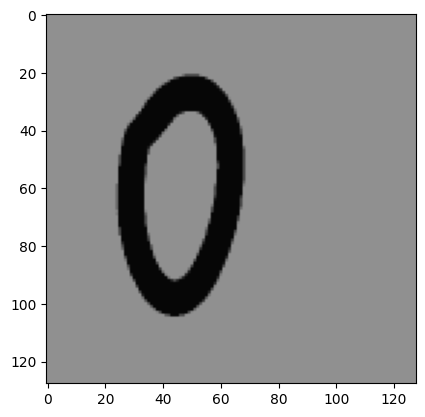

In [ ]:
# Trainable Average Pooling Layer

class TrainableAveragePooling2DTest(tf.keras.layers.AveragePooling2D):
    def __init__(self, pool_size=(2, 2),
                 strides=None, padding="valid",
                 data_format=None,
                 weights_initializer=None,
                 bias_initializer=None,
                 **kwargs):

        super().__init__(pool_size, strides, padding, data_format, **kwargs)

        weights_initializer = weights_initializer or tf.keras.initializers.RandomUniform(minval=0.5, maxval=1)
        bias_initializer = bias_initializer or tf.keras.initializers.RandomUniform(minval=0, maxval=0.5)

        self.W = self.add_weight("coef", shape=(), initializer=weights_initializer)
        self.b = self.add_weight("bias", shape=(), initializer=bias_initializer)

    def call(self, x, **kwargs):
        return (self.W * super().call(x)) + self.b

pooling = TrainableAveragePooling2DTest(strides=2, padding="same")
out_P = pooling(next(train_ds.as_numpy_iterator())[0][tf.newaxis])
plt.imshow(out_P[0]), out_P.shape

#### **`TrainableAveragePooling2D` (S2, S4)**

(<matplotlib.image.AxesImage at 0x7e5fe492cf10>, TensorShape([1, 128, 128, 3]))

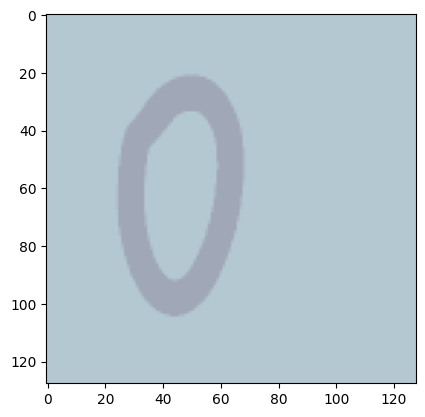

In [ ]:
class TrainableAveragePooling2D(tf.keras.layers.AveragePooling2D):
    def __init__(self, pool_size=(2, 2),
                 strides=2,
                 padding="SAME",
                 data_format=None,
                 weights_initializer=None,
                 bias_initializer=None, **kwargs):
        super().__init__(pool_size, strides, padding, data_format, **kwargs)

        self.weights_initializer = weights_initializer or tf.keras.initializers.RandomUniform(minval=0.25, maxval=1)
        self.bias_initializer = bias_initializer or tf.keras.initializers.RandomUniform(minval=0.5, maxval=1)

    def build(self, input_shape):
        super().build(input_shape)
        self.W = self.add_weight("W", shape=(1, 1, 1, input_shape[-1]), initializer=self.weights_initializer)
        self.b = self.add_weight("b", shape=(1, 1, 1, input_shape[-1]), initializer=self.bias_initializer)

    def call(self, x, **kwargs):
        return tf.keras.activations.sigmoid((self.W * super().call(x)) + self.b)


pooling = TrainableAveragePooling2D(strides=2, padding="same")
out_P = pooling(next(train_ds.as_numpy_iterator())[0][tf.newaxis])
plt.imshow(out_P[0]), out_P.shape

#### Partially Connected 2d Convolutional layer initial build

In [ ]:
PARTIAL_CONNECTION_MAP = np.zeros(shape=(6, 16))

for i, j in zip(range(6), range(6)):
    max = 3 + i
    PARTIAL_CONNECTION_MAP[i:max, j] = 1
    PARTIAL_CONNECTION_MAP[:(max // 6) * (max % 6), j] = 1

for i, j in zip(range(6), range(6, 12)):
    max = 4 + i
    PARTIAL_CONNECTION_MAP[i:max, j] = 1
    PARTIAL_CONNECTION_MAP[:(max // 6) * (max % 6), j] = 1

PARTIAL_CONNECTION_MAP[0:2, 12] = 1
PARTIAL_CONNECTION_MAP[3:5, 12] = 1

PARTIAL_CONNECTION_MAP[1:3, 13] = 1
PARTIAL_CONNECTION_MAP[4:6, 13] = 1

PARTIAL_CONNECTION_MAP[0, 14] = 1
PARTIAL_CONNECTION_MAP[-1, 14] = 1
PARTIAL_CONNECTION_MAP[2:4, 14] = 1

PARTIAL_CONNECTION_MAP[:, 15] = 1

PARTIAL_CONNECTION_MAP.astype("int32"), PARTIAL_CONNECTION_MAP.shape

(array([[1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]], dtype=int32),
 (6, 16))

In [ ]:
# Custom initialization for keras conv2d layer| worked

class TestPartiallyConnectedConv2d(tf.keras.layers.Convolution2D):
    def build(self, input_shape):
        # set the unconnected filters to 0 so the outputs are 0
        super().build(input_shape)

        #                (i, j)
        # self.kernel[:, :, 2, 0].assign(0) #!!
        # self.kernel[:, :, 0:2, 1].assign(0) #!!
        # print(self.kernel)

        for i in range(6):
            for j in range(16):
                if PARTIAL_CONNECTION_MAP[i, j]:
                    self.kernel[:, :, i, j].assign(0)

        print(tf.transpose(self.kernel[:, :, :, 0]))
        print(tf.transpose(self.kernel[:, :, :, 1]))
        print(tf.transpose(self.kernel[:, :, :, 2]))

        # # Another method would be to have a multiplier...
        # test = self.kernel
        # multiplier = np.ones(shape=self.kernel.shape)

        # for i in range(self.kernel.shape[-1]):
        #     multiplier[:, :, :, i][:, :, 1:] = multiplier[:, :, :, i][:, :, 1:] * 0

        # self.kernel = tf.Variable(multiplier, trainable=True, dtype="float32")
        # print(multiplier, multiplier.shape)

    def call(self, x):
        return super().call(x)

out = tf.keras.layers.Convolution2D(6, (3, 3))(out_P)

NUM_TEST_FILTERS = 16
C_test = TestPartiallyConnectedConv2d(NUM_TEST_FILTERS, (5, 5), padding="valid")
out_C = C_test(out)

# for i in range(NUM_TEST_FILTERS):
#     plt.imshow(tf.transpose(tf.transpose(out_C[0])[i]))
#     plt.show()

tf.Tensor(
[[[ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.05463558  0.10000

#### **`PartialConv2D` (C3)**

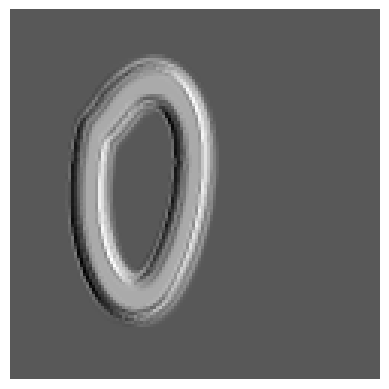

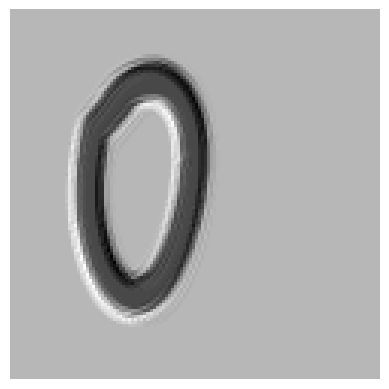

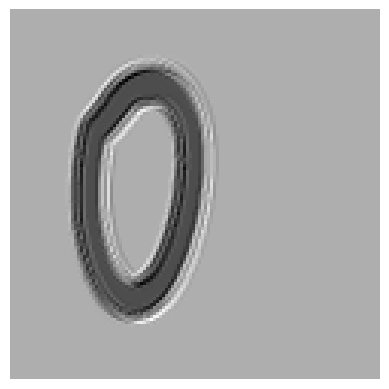

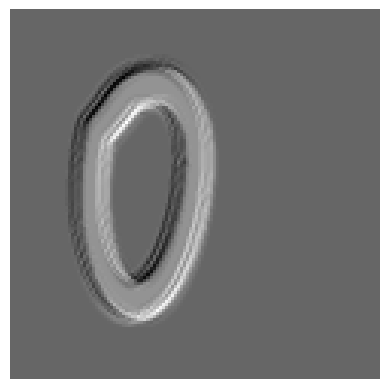

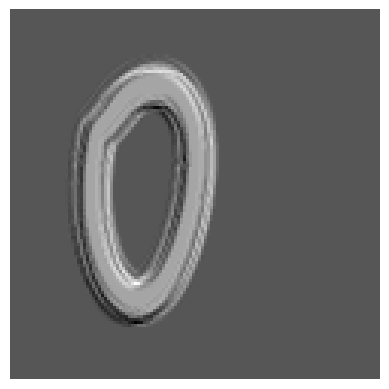

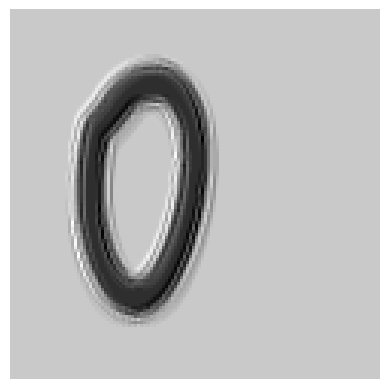

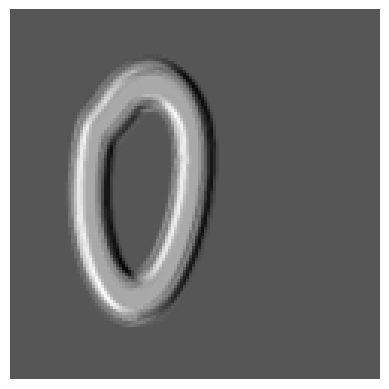

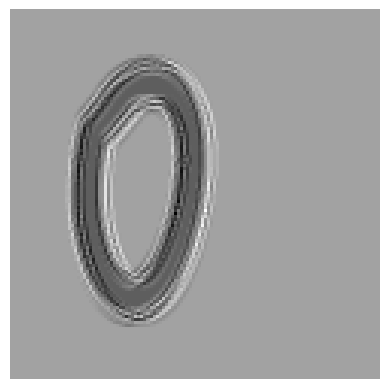

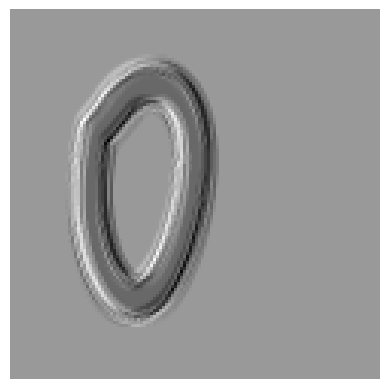

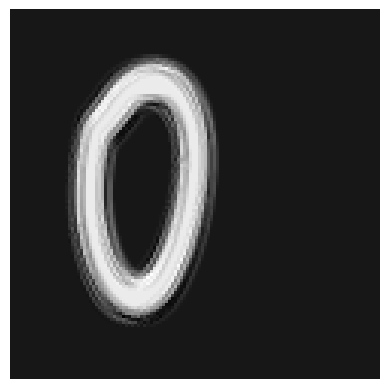

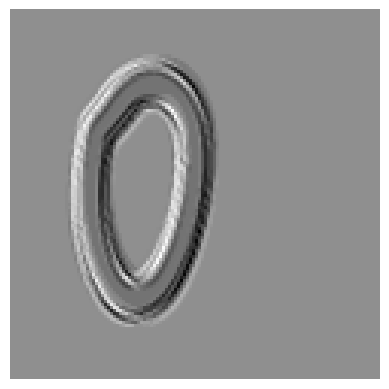

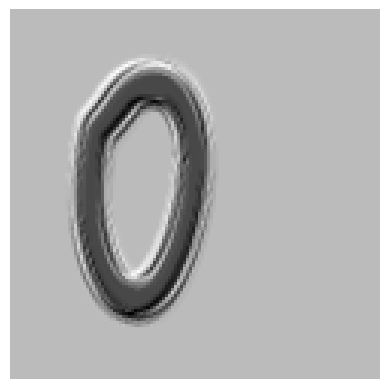

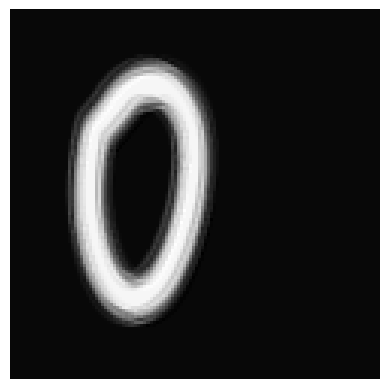

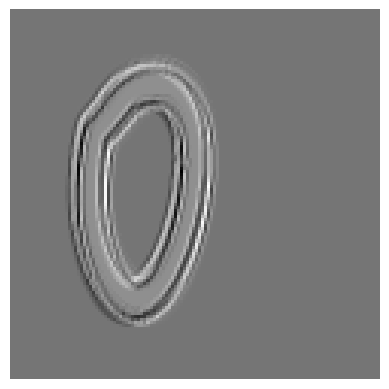

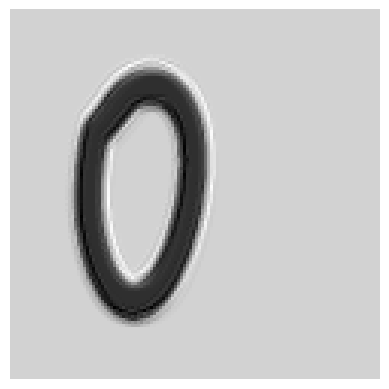

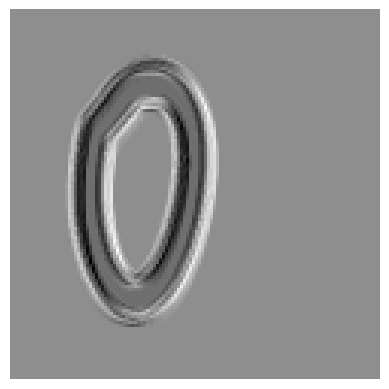

In [ ]:
class PartialConv2D(tf.keras.layers.Conv2D):
    def __init__(self, connection_map, *args, **kwargs):
        super().__init__(*args, use_bias=False, **kwargs)
        self.connection_map = connection_map

    def build(self, input_shape):
        super().build(input_shape)

        for i in range(self.connection_map.shape[0]):
            for j in range(self.connection_map.shape[1]):
                if not self.connection_map[i, j]:
                    self.kernel[:, :, i, j].assign(0)

    def call(self, x, **kwargs):
        self.kernel.assign(self.kernel * self.connection_map)
        return super().call(x)

out = tf.keras.layers.Convolution2D(6, (3, 3))(out_P)

NUM_TEST_FILTERS = 16
C_build = PartialConv2D(PARTIAL_CONNECTION_MAP, NUM_TEST_FILTERS, (5, 5), padding="valid")
out_C = C_build(out)

C_build.kernel[:, :, 0, 0]

for i in range(NUM_TEST_FILTERS):
    plt.imshow(out_C[0, :, :, i], cmap="gray")
    plt.axis("off")
    plt.show()

In [ ]:
# Testing if it will work in back propagation
# Ensuring that back propagation does not change the "unconnected" maps

Clayer = PartialConv2D(PARTIAL_CONNECTION_MAP, NUM_TEST_FILTERS, (3, 3), padding="same")
Clayer2 = PartialConv2D(PARTIAL_CONNECTION_MAP, NUM_TEST_FILTERS, (3, 3), padding="same")

with tf.GradientTape() as g:
    out = Clayer(tf.keras.layers.Convolution2D(6, (3, 3))(out_P))

    gradients = g.gradient(out, sources=Clayer.trainable_variables)
    # gradients[0] = gradients[0] * PARTIAL_CONNECTION_MAP

    tf.keras.optimizers.SGD(learning_rate=0.001).apply_gradients(zip(gradients, Clayer.trainable_variables))

    Clayer(tf.keras.layers.Convolution2D(6, (3, 3))(out)) # running the same layer after shows that the kernels are indeed converted to their sparse state when the layer is called.


Clayer.trainable_variables[0][:, :, :, 0]

<tf.Tensor: shape=(3, 3, 6), dtype=float32, numpy=
array([[[ -3.6811388 , -15.905741  ,  -0.6683136 ,   0.        ,
           0.        ,   0.        ],
        [ -3.5071073 , -16.150732  ,  -0.57721776,   0.        ,
           0.        ,   0.        ],
        [ -3.694572  , -15.935758  ,  -0.63638985,   0.        ,
           0.        ,   0.        ]],

       [[ -3.714549  , -16.179472  ,  -0.664967  ,   0.        ,
           0.        ,   0.        ],
        [ -3.5447254 , -16.139723  ,  -0.7628021 ,   0.        ,
           0.        ,   0.        ],
        [ -3.4779794 , -16.311598  ,  -0.49420354,   0.        ,
           0.        ,   0.        ]],

       [[ -3.5162826 , -16.104761  ,  -0.7240467 ,   0.        ,
           0.        ,   0.        ],
        [ -3.7630486 , -16.22716   ,  -0.7506622 ,   0.        ,
           0.        ,   0.        ],
        [ -3.4540834 , -16.176495  ,  -0.73401296,   0.        ,
           0.        ,   0.        ]]], dtype=float32)>

#### **`scaledTanh` Activation (C6)**

In [ ]:
A = 1.7159
S = 2 / 3
def scaledTanh(x): return A * tf.math.tanh(S * x)

#### Euclidean Radial Basis Function initial build

##### Initial RBF weights

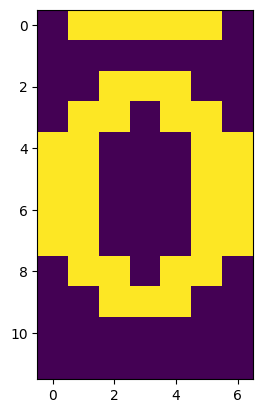

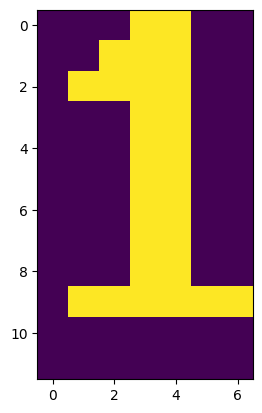

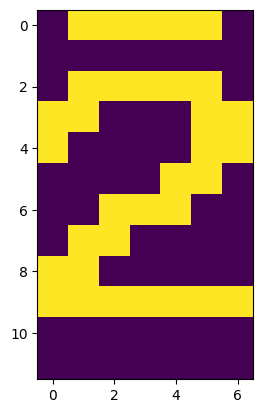

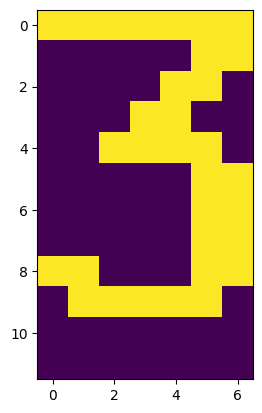

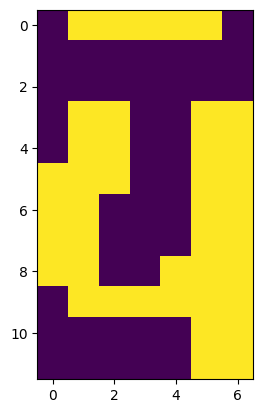

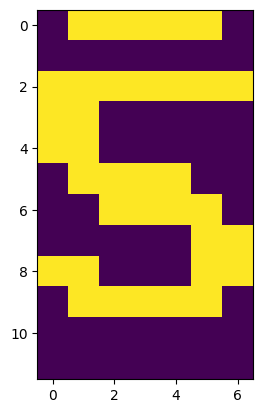

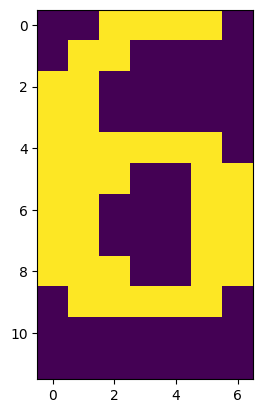

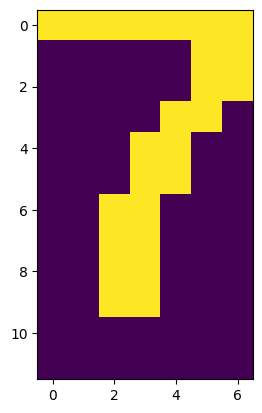

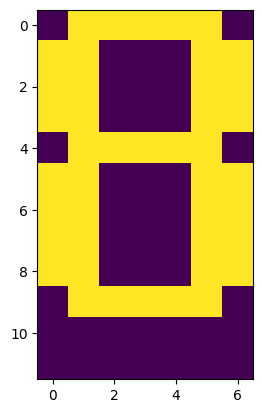

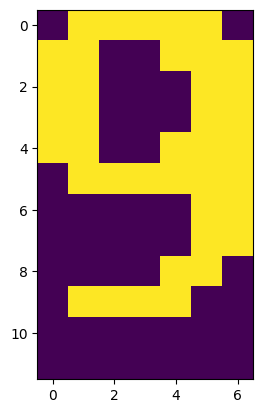

In [ ]:
# initial RBF weights for digits 0-9 taken from https://github.com/mattwang44/LeNet-from-Scratch/blob/master/utils/RBF_initial_weight.py

bitmap = np.zeros((10,84))
bitmap[0]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, +1, +1, +1, -1, -1] + \
    [-1, +1, +1, -1, +1, +1, -1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, -1, +1, +1, -1] + \
    [-1, -1, +1, +1, +1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[1]=np.array([
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, +1, +1, +1, -1, -1] + \
    [-1, +1, +1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[2]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, +1, +1, -1] + \
    [-1, -1, +1, +1, +1, -1, -1] + \
    [-1, +1, +1, -1, -1, -1, -1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [+1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[3]=np.array([
    [+1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, +1, +1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[4]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, +1, +1, -1, -1, +1, +1] + \
    [-1, +1, +1, -1, -1, +1, +1] + \
    [+1, +1, +1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, +1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] \
])
bitmap[5]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [+1, +1, +1, +1, +1, +1, +1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [-1, +1, +1, +1, +1, -1, -1] + \
    [-1, -1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[6]=np.array([
    [-1, -1, +1, +1, +1, +1, -1] + \
    [-1, +1, +1, -1, -1, -1, -1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [+1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, +1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, +1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[7]=np.array([
    [+1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, +1, +1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, +1, +1, -1, -1, -1] + \
    [-1, -1, +1, +1, -1, -1, -1] + \
    [-1, -1, +1, +1, -1, -1, -1] + \
    [-1, -1, +1, +1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[8]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[9]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, -1, -1, +1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, +1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, +1, +1, -1] + \
    [-1, +1, +1, +1, +1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])

bitmap = bitmap.astype("float32")
for image in bitmap:
    plt.imshow(np.reshape(image, newshape=(12, 7)))
    plt.show()

##### Initial Implementation

In [ ]:
class RBFTest(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.W = tf.Variable(bitmap)

    def call(self, x, **kwargs):
        return tf.reduce_sum((tf.tile(x, multiples=[bitmap.shape[0], 1]) - bitmap) ** 2, axis=1)

RBFTest()(np.random.normal(size=(1, 84))) # working initial implementation

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([148.45868, 172.70993, 165.43506, 159.66895, 149.10777, 149.83156,
       135.51645, 165.10916, 145.00513, 158.41066], dtype=float32)>

#### **Euclidean Radial Basis Function `RBF` (OUTPUT)**

In [ ]:
input = tf.random.normal(shape=(2, 3))
d1 = tf.keras.layers.Dense(84, activation="elu")(input)
d1

<tf.Tensor: shape=(2, 84), dtype=float32, numpy=
array([[ 0.08437452, -0.02169438, -0.19019498,  0.32198733, -0.0962007 ,
        -0.10684289, -0.04193331, -0.01298726, -0.08031214, -0.17527802,
         0.3376028 , -0.20596956,  0.3841939 ,  0.13548572, -0.02796996,
         0.18353736,  0.53781074, -0.21297817, -0.05725447,  0.02802069,
         0.31448415,  0.01670392, -0.13060415, -0.167889  , -0.13731466,
         0.19895163, -0.16916631, -0.03396252, -0.22856867,  0.01263982,
        -0.18708062,  0.14610974, -0.033421  , -0.05176305,  0.28296983,
         0.32533556, -0.06452569, -0.07565358, -0.05133807,  0.1008071 ,
         0.17266983,  0.1658667 ,  0.16249608,  0.27449226, -0.01949005,
         0.35160238,  0.05828483,  0.29654476, -0.16351105, -0.29101604,
         0.19529818, -0.18038265,  0.0027843 , -0.00347658, -0.18156704,
        -0.0416095 ,  0.04352657,  0.18929642,  0.16209942, -0.13237129,
        -0.02680629, -0.21788333,  0.17917834,  0.14575693,  0.1294018 ,
  

In [ ]:
class RBF(tf.keras.layers.Layer):
    def __init__(self, weights, **kwargs):
        super().__init__(**kwargs)
        self.W = weights # weights are kept constant and are not adaptatble

    def call(self, x, **kwargs):
        return tf.reduce_sum((tf.tile(x[:, np.newaxis], multiples=[1, self.W.shape[0], 1]) - self.W) ** 2, axis=2)

rbf_build = RBF(bitmap)

for i in range(2):
    with tf.GradientTape() as tape:
        out = rbf_build(d1)
        g = tape.gradient(out, rbf_build.trainable_variables)
        tf.keras.optimizers.SGD(learning_rate=0.001).apply_gradients(zip(g, rbf_build.trainable_variables)) # works during back propagation

#### **Loss Function**

In [ ]:
def lenet5_loss(y_true, y_pred):
    A = tf.cast(~tf.cast(y_true, dtype="bool"), dtype="float32")
    return tf.reduce_mean(tf.reduce_sum(y_pred * y_true, axis=1) + tf.math.log((tf.math.exp(-1.)) + tf.reduce_sum(tf.math.exp(-y_pred * A))))

#### **`LenetInit`** **Initialiser**

In [ ]:
class LenetInit(tf.keras.initializers.Initializer):
    def __init__(self, c=2.4):
        self.c = c

    def __call__(self, shape, dtype, **kwargs):
        return tf.random.uniform(shape=shape,minval=-(self.c / shape[0]), maxval=(self.c / shape[0]))

    def get_config(self):
        return {"c": self.c}


#### Model Test

In [ ]:
model_test = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 1)),
    tf.keras.layers.Convolution2D(filters=6, kernel_size=(5, 5)), # C1
    TrainableAveragePooling2D(), # S2

    PartialConv2D(PARTIAL_CONNECTION_MAP, filters=16, kernel_size=(5, 5)), #C3

    TrainableAveragePooling2D(), # S4
    tf.keras.layers.Convolution2D(filters=120, kernel_size=(5, 5)), # C5

    tf.keras.layers.Flatten(), # Flatten

    tf.keras.layers.Dense(84, activation=scaledTanh), #F6
    RBF(bitmap) # OUTPUT
])

x = next(mnist_ds.take(1).as_numpy_iterator())

out = model_test(x[0][np.newaxis, ..., np.newaxis])

model_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 trainable_average_pooling2  (None, 14, 14, 6)         12        
 d_1 (TrainableAveragePooli                                      
 ng2D)                                                           
                                                                 
 partial_conv2d_3 (PartialC  (None, 10, 10, 16)        2400      
 onv2D)                                                          
                                                                 
 trainable_average_pooling2  (None, 5, 5, 16)          32        
 d_2 (TrainableAveragePooli                                      
 ng2D)                                                           
                                                        

In [ ]:
def test_loss(y_true, y_pred):
    A = tf.cast(~tf.cast(y_true, dtype="bool"), dtype="float32")
    return tf.reduce_mean(tf.reduce_sum(y_pred * y_true, axis=1) + tf.math.log((tf.math.exp(-1.)) + tf.reduce_sum(tf.math.exp(-y_pred * A))))

test_loss(next(mnist_ds.take(1).as_numpy_iterator())[1], tf.random.normal(shape=(1, 10)))

<tf.Tensor: shape=(), dtype=float32, numpy=3.28987>

In [106]:
model_test.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001),
    loss=test_loss,
)

model_test.fit(mnist_ds.batch(32).prefetch(8), epochs=10, use_multiprocessing=True, workers=32)

Epoch 1/10
1875/1875 [==============================] - 16s 7ms/step - loss: 43.1965
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 32.1521
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 28.5781
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 25.8352
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 23.4656
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 21.6156
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 20.1440
Epoch 8/10
1875/1875 [==============================] - 14s 7ms/step - loss: 18.9280
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 17.9551
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - loss: 17.1817


In [107]:
sample = next(mnist_ds.shuffle(buffer_size=128).batch(10).take(1).as_numpy_iterator())
pred = np.argmin(model_test.predict(sample[0]), axis=1)

pred == np.argmax(sample[1], axis=1)

1/1 [==============================] - 0s 88ms/step


array([ True,  True,  True,  True,  True, False, False, False,  True,
        True])

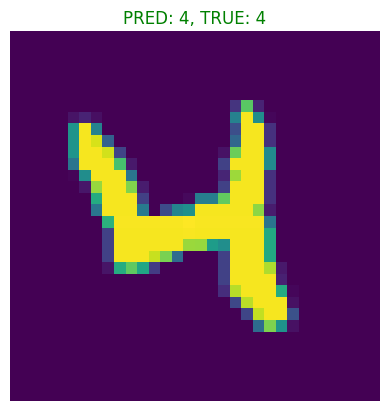

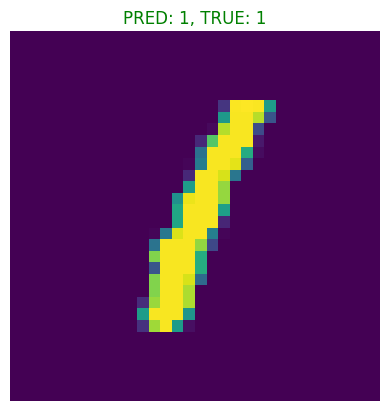

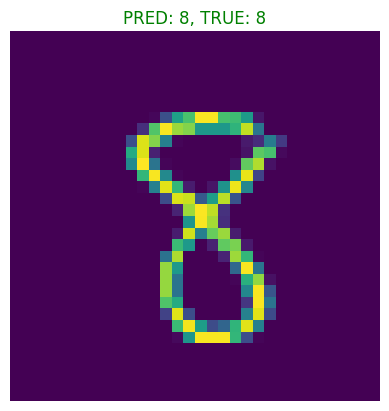

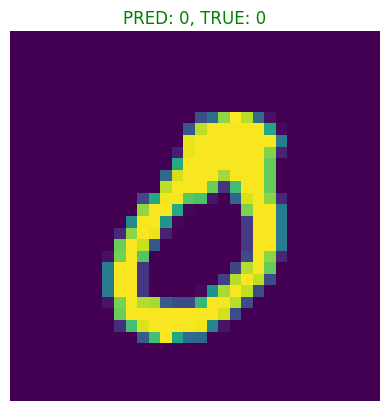

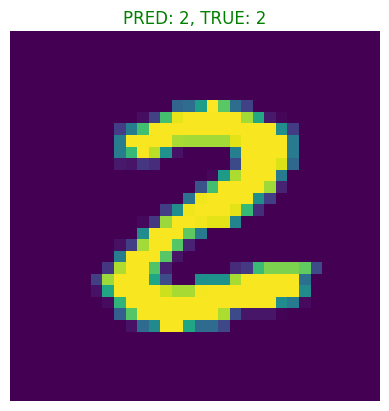

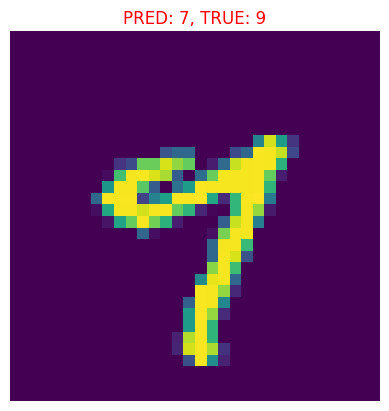

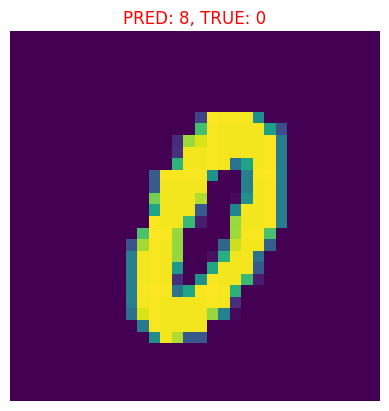

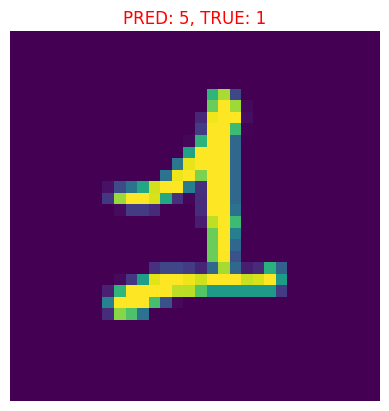

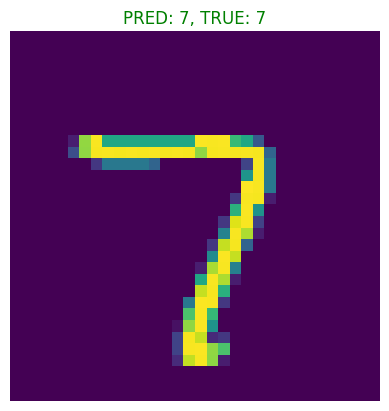

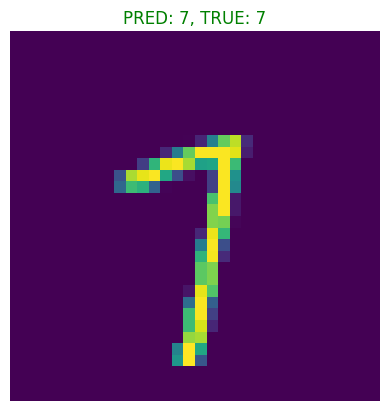

In [108]:
for (x, y_pred), y_true in zip(zip(sample[0], pred), np.argmax(sample[1], axis=1)):
    plt.axis("off")
    plt.title(f"PRED: {y_pred}, TRUE: {y_true}", fontdict={
        "color": "green" if y_pred == y_true else "red"
        })
    plt.imshow(x)
    plt.show()

In [ ]:
model_test.save("/content/drive/MyDrive/test_train_10epochs-02-09-2023")

#### **Model**

In [ ]:
class Lenet5(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.C1 = tf.keras.layers.Convolution2D(filters=6,
                                                kernel_size=(5, 5),
                                                input_shape=(32, 32, 1),
                                                kernel_initializer=LenetInit(),
                                                name="C1") # C1

        self.S2 = TrainableAveragePooling2D(name="S1") # S2

        self.C3 = PartialConv2D(PARTIAL_CONNECTION_MAP,
                                filters=16,
                                kernel_size=(5, 5),
                                kernel_initializer=LenetInit(),
                                name="C3") #C3

        self.S4 = TrainableAveragePooling2D(name="S4") # S4

        self.C5 = tf.keras.layers.Convolution2D(filters=120,
                                                kernel_size=(5, 5),
                                                kernel_initializer=LenetInit(),
                                                name="C5") # C5

        self.flatten = tf.keras.layers.Flatten(name="Flatten") # Flatten

        self.F6 = tf.keras.layers.Dense(84,
                                        activation=scaledTanh,
                                        kernel_initializer=LenetInit(),
                                        name="F6") #F6

        self.out = RBF(bitmap, name="output") # OUTPUT


    def call(self, input):
        x = self.C1(input)
        x = self.S2(x)
        x = self.C3(x)
        x = self.S4(x)
        x = self.C5(x)
        x = self.flatten(x)
        x = self.F6(x)
        return  self.out(x)

lenet5 = Lenet5()
lenet5(next(mnist_ds.batch(32).as_numpy_iterator())[0])
# lenet5.compile(
#     optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001),
#     loss=test_loss,
# )

lenet5.summary()
# lenet5.fit(mnist_ds.batch(32))

Model: "lenet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 multiple                  156       
                                                                 
 S1 (TrainableAveragePoolin  multiple                  12        
 g2D)                                                            
                                                                 
 C3 (PartialConv2D)          multiple                  2400      
                                                                 
 S4 (TrainableAveragePoolin  multiple                  32        
 g2D)                                                            
                                                                 
 C5 (Conv2D)                 multiple                  48120     
                                                                 
 Flatten (Flatten)           multiple                  0    

#### Custom Training Loop Test

In [ ]:
class Lenet5TrainerTest(object):
    def __init__(self):
        self.T_SUBSET_SIZE = 8000
        self.T_DATASET = mnist_ds.take(self.T_SUBSET_SIZE)
        self.T_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.T_LOSS = lenet5_loss
        self.T_BATCH_SIZE = 32
        self.T_EPOCHS = 1

        self.training_loss = 0

    def step(self, x, y):
        with tf.GradientTape() as tape:
            out = lenet5(x)
            self.training_loss = (self.training_loss + self.T_LOSS(y, out))

        grads = tape.gradient(self.training_loss, lenet5.trainable_variables)
        self.T_OPTIMIZER.apply_gradients(zip(grads, lenet5.trainable_variables))

    def train(self):
        for i in range(self.T_EPOCHS):
            self.training_loss = 0

            for x, y in self.T_DATASET.batch(self.T_BATCH_SIZE):
                self.step(x, y)

            print((self.training_loss / self.T_SUBSET_SIZE).numpy())

trainer = Lenet5TrainerTest()
trainer.train()

1.9295797


In [ ]:
sample = next(mnist_ds.batch(20).take(1).as_numpy_iterator())
for p, y in zip(lenet5(sample[0]), sample[1]):
    print(np.argmax(y), np.argmin(p))

7 3
7 3
4 3
0 3
2 3
8 3
1 3
0 3
5 3
6 3
1 3
0 3
1 3
9 3
3 3
1 3
6 3
3 3
6 3
9 3


#### Custom Optimisation Test (simplified Stochastic Diagonal Levenberg-Marquardt method) - using `tensorflow_addons`
> *... where an individual learning
rate (step size) is computed for each parameter (weight)
before each pass through the training set ...*

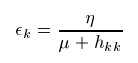

here the learning rate is divided by the hessian values of the gradient added to a preset constant. The paper makes an approximation of the hessian, however I will be making a simpler version. Instead of the approxiamte hessian values, the mean value of the hessian will be added.

In [ ]:
len(lenet5.trainable_variables)

11

In [ ]:
T_SUBSET_SIZE = 8000
T_DATASET = mnist_ds.take(T_SUBSET_SIZE)
T_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
T_LOSS = lenet5_loss
T_BATCH_SIZE = 32
T_EPOCHS = 1
training_loss = 0

In [ ]:
instance = next(T_DATASET.batch(500).take(1).as_numpy_iterator())

with tf.GradientTape() as test_htape:
    with tf.GradientTape() as test_jtape:
        out = tf.reduce_mean(lenet5(instance[0]))
    jaccobeans = test_jtape.gradient(out, lenet5.trainable_variables)

test_hessians = test_htape.gradient(jaccobeans, lenet5.trainable_variables)

In [ ]:
for i in range(len(lenet5.trainable_variables)):
    print(np.sum(test_hessians[i] / test_hessians[i].numpy().size) / 32)  # average hessian values
    # some are negative, therefore the aboslute value will be taken.

-0.046435095369815826
-0.04978257417678833
0.015222562476992607
-0.17864742875099182
0.17962805926799774
-0.6888518333435059
0.585761547088623
0.10900343954563141
0.17352277040481567
-0.14588376879692078
-0.46682098507881165


In [ ]:
for i in range(len(lenet5.trainable_variables)):
    print(np.abs(np.sum(test_hessians[i] / test_hessians[i].numpy().size) / 32))  # average hessian values

0.046435095369815826
0.04978257417678833
0.015222562476992607
0.17864742875099182
0.17962805926799774
0.6888518333435059
0.585761547088623
0.10900343954563141
0.17352277040481567
0.14588376879692078
0.46682098507881165


In [ ]:
# list of learning rates
test_lr_list = list(map(lambda i: np.abs(np.sum(test_hessians[i] / test_hessians[i].numpy().size) / 32), range(len(lenet5.trainable_variables))))

In [ ]:
# have layer to optimiser mapping
test_optimisers = [tf.keras.optimizers.SGD(learning_rate=lr) for lr in test_lr_list]
test_optimisers

In [ ]:
for op in test_optimisers:
    print(op.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.046435095>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.049782574>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0152225625>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.17864743>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.17962806>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.68885183>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.58576155>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.10900344>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.17352277>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.14588377>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.46682099>


#### **Custom Training Loop with Custom Optimisation**

In [ ]:
lenet5 = Lenet5()


def lr_step(hessian): return np.abs(np.sum(hessian / hessian.numpy().size) / 32)


class Lenet5Trainer(object):
    def __init__(self,
                 optimiser="adam",
                 subset_size=8000,
                 loss=lenet5_loss,
                 batch_size=32,):

        self.SUBSET_SIZE = subset_size
        self.DATASET = mnist_ds.take(self.SUBSET_SIZE)
        self.OPTIMISERS_MAPPING = []
        self.LOSS = loss
        self.BATCH_SIZE = batch_size
        self.EPOCHS = None
        self.OPTIMISER = optimiser

        self.training_loss = 0

    def step(self, x, y, i):
        with tf.GradientTape() as tape:
            print(f"\rE{i + 1}: ..", end="")
            out = lenet5(x)
            self.training_loss = (self.training_loss + self.LOSS(y, out))

        grads = tape.gradient(self.training_loss, lenet5.trainable_variables)

        print(f"\rE{i + 1}: ...", end="")
        for idx, op in enumerate(self.OPTIMISERS_MAPPING):
            op.apply_gradients(zip([grads[idx]], [lenet5.trainable_variables[idx]]))

    def train(self, epochs=1, lr=0.0005, mu=0.02):
        print(f"Subset Size: {self.SUBSET_SIZE}, Batch Size: {self.BATCH_SIZE}, Optimiser: {self.OPTIMISER}, Loss: {self.LOSS.__name__}\n")

        self.EPOCHS = epochs

        # calculate the hessians on first 500 samples of data
        for i in range(self.EPOCHS):
            s = time.time()

            instance = next(self.DATASET.batch(500).take(1).as_numpy_iterator())

            with tf.GradientTape() as htape:
                with tf.GradientTape() as jtape:
                    out = tf.reduce_mean(lenet5(instance[0]))
                jaccobeans = jtape.gradient(out, lenet5.trainable_variables)

            hessians = htape.gradient(jaccobeans, lenet5.trainable_variables)

            learning_step_list = np.array(list(map(lambda hessian: lr_step(hessian), hessians)))
            learning_step_list = lr / (mu + learning_step_list)

            # get weight to optimiser mapping
            self.OPTIMISERS_MAPPING = [type(tf.keras.optimizers.get(self.OPTIMISER))(learning_rate=lr) for lr in learning_step_list]

            self.training_loss = 0

            for x, y in self.DATASET.batch(self.BATCH_SIZE):
                print(f"\rE{i + 1}: .", end="")
                self.step(x, y, i)

            print(f"\rE{i + 1}: loss - {(self.training_loss / self.SUBSET_SIZE).numpy()}  [{np.round(time.time() - s, 2)}s]")


trainer = Lenet5Trainer(subset_size=10000)
trainer.train(epochs=5)

Subset Size: 10000, Batch Size: 32, Optimiser: adam, Loss: lenet5_loss

E1: loss - 1.4750946760177612  [13.76s]
E2: loss - 0.7207867503166199  [13.76s]
E3: loss - 0.5985327363014221  [13.88s]
E4: loss - 0.5446578860282898  [20.65s]
E5: loss - 0.5508077144622803  [13.64s]


## **Log**

**[12/08/23 - 18:27]**
* Finished data processing
* Began reading the [LeNet](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) paper for details on task and architecture

**[26/08/23 - 22:59]**
* Planned how the cutom arcitecture of LeNet5 was going to be made (trainable pooling, partial convolution, RBF layer)
* Made a custom class for a trainable pooling layer
* Made a custom partial convolutional layer by zeroing out the specifics portions of the filter through the use of a predifined partial connection map. **Need to make a more generalised design of the class**

**[29/08/23 - 23:32]**
* Made build version of `TrainableAveragePooling2D` and `PartialConv2D`
* Found a solution for keeping the kernels of the Partial Convolutional Layer sparse after backpropagation by multiplying the gradients by the connection map matrix before the gradients are applied.
* Made the `scaledTanh` activation function.
* Began preparing the implementation of the RBF output layer.

**[30/08/2023]**
* finished the impementation of the RBF output layer
* Editted the implementation of the partial convolutional layer

**[31/08/2023 - 23:16]**
* made an eddited version of the existing dataset that only includes the numerical values
* make a sample sequential model using all of the custom components and tested with an image from the dataset. The forward propagation was successful and so was the maintaining of the dimensions.

**[01/09/2023]**
* made and edit to the `TrainableAveragePooling2D` layer, initially the weights were set as singular scalar vectors, while in the paper they are vectors multiplying the pooling layer output along the depth dimension.
* implemented the loss function presented in the paper.
* made an accurate, working test model of Lenet5 🥳, using a sequential model.

**[04/09/2023]**
* Made a custom Lenet5 Model using model subclassing

**[05/09/2023]**
* Made the initialiser that was used to train the the network.

**[22/09/2023]**
* Editted the custom training loop
* Encoutered error - model was not training effectively
* Began to implement a test version of the simplified Stochastic Diagonal Levenberg-Marquardt method

**[23/09/2023]**
* Re-editted the custom training loop. Turned it into a `Lenet5Trainer` class.
* Fixed ineffective training error
* Added to the test implementation of the custom optimisation.

**[30/09/23 - 22:48]**
* Finished making a working lenet 5 trainer using a custom tensorflow training loop.
* Integrated a simplified version of the optimisation technique used in the paper.
* Trained the network for 5 epochs on a subset of 10000 images from the training set.